# NHL 2009-2018 Draft data

Dataset downloaded from [Kaggle](http://localhost:8888/?token=b1eb61f8ed72cf51005640919abafb625e74268313819ce3).

# Statistical Hypothesis Tests

This notebook presents hypothesis testing performed on the modified NHL 2009-2018 Draft dataset.

Previous steps included data cleaning and feature extraction. Summary of each step is presented below, for details see notebook `notebooks/feature_extraction/nhl_cleanup_extraction.ipynb`.

Cleanup summary:

* summarized positions
    * corrected for consistency
    * C/RW, C/LW, _etc._, C/W, F = C
    * L/RW, W = RW
    * player who can play center are assumed to be centers for the purposes of this analysis
    * universal (left/right) wingers are assumed to be right wingers
    * for details, see notebook `notebooks/feature_extraction/nhl_cleanup_extraction.ipynb`

New features added during feature extraction:

* `year`: int, year of NHL draft, extracted from .csv file names
* `num_teams`: int, number of teams in each draft year
* `round_ratio`: float, ratio of each pick: 
    * $\text{round_ratio}=\large{\frac{\text{# Overall}}{\text{number of teams}}}$ 
    * number of teams represents number of picks per round
    * each overall pick number (e.g., 171) is divided by the number of picks per round to determine in which round (and how late in the round, via the ratio) was each prospect selected
    * \- 1 is needed to ensure proper boundary between rounds
    * so, for example, for pick #171 $\text{round ratio}=\frac{171 - 1}{30} = 5.67$
* `round`: int, round in which a prospect was selected
    * `round_ratio` is rounded down and 1 is added
    * $\text{round} = \text{int}(\text{round ratio}) + 1$
* `1st_round`: boolean, whether the prospect was selected in the $1^{st}$ round
    * one-hot encoding for $1^{st}$ round picks
    * True if `round` == 1, False otherwise
* `gpg`: float, average goals per game
* `apg`: float, average assists per game
* `ppg`: float, average points per game
* for details, see notebook `notebooks/feature_extraction/nhl_cleanup_extraction.ipynb`

### Types of Statistical Hypothesis Tests

From [machinelearningmastery.com](https://machinelearningmastery.com/statistical-hypothesis-tests-in-python-cheat-sheet/):

There are hundreds of statistical hypothesis tests available, with multiple types of tests available for a given concern, answers that they give to a question are probabilistic in their nature rather than exact. Some of the commonly used ones in Machine Learning include:

* Normality Tests
    * Shapiro-Wilk Test
    * D’Agostino’s K^2 Test
    * Anderson-Darling Test
* Correlation Tests
    * Pearson’s Correlation Coefficient
    * Spearman’s Rank Correlation
    * Kendall’s Rank Correlation
    * Chi-Squared Test
* Parametric Statistical Hypothesis Tests
    * Student’s t-test
    * Paired Student’s t-test
    * Analysis of Variance Test (ANOVA)
    * Repeated Measures ANOVA Test
* Nonparametric Statistical Hypothesis Tests
    * Mann-Whitney U Test
    * Wilcoxon Signed-Rank Test
    * Kruskal-Wallis H Test
    * Friedman Test

### Characteristics of each test
    
Each test has its application scope, assumptions, and interpretation of results.

_Note_, when it comes to assumptions such as the expected distribution of data or sample size, the results of a given test are likely to degrade gracefully rather than become immediately unusable if an assumption is violated.

### Requirements to data samples

Generally, data samples need to be representative of the domain and large enough to expose their distribution to analysis.

In some cases, the data can be corrected to meet the assumptions, such as correcting a nearly normal distribution to be normal by removing outliers, or using a correction to the degrees of freedom in a statistical test when samples have differing variance, to name two examples.

In the case of NHL Draft dataset, we have complete draft records for 2009-2018 NHL Draft seasons, so these records represent a **full population of players drafted to the NHL from 2009 to 2018.**

## Load data
### Import dependencies

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from math import erf  # Python standard library
from math import sqrt # Python standard library
from time import time
sns.set()
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
#pd.set_option('display.width', 1000)

### Load the dataset

In [3]:
draft_data_path = '../../data/nhl_draft_picks_2009-2018.csv'
t = time()
df = pd.read_csv(draft_data_path)
df = df.rename(columns={'Unnamed: 0': 'id'})
elapsed = time() - t
print("----- DataFrame with NHL Draft Data loaded"
      "\nin {0:.2f} seconds".format(elapsed) + 
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(df.shape[0], df.shape[1]) + 
      "\n-- Column names:\n", df.columns)

----- DataFrame with NHL Draft Data loaded
in 0.06 seconds
with 2,119 rows
and 32 columns
-- Column names:
 Index(['id', 'Overall', 'Team', 'Player', 'Nat.', 'Pos', 'Age', 'To',
       'Amateur Team', 'GP', 'G', 'A', 'PTS', '+/-', 'PIM', 'GP.1', 'W', 'L',
       'T/O', 'SV%', 'GAA', 'year', 'num_teams', 'round_ratio', 'round',
       '1st_round', 'gpg', 'apg', 'ppg', 'name', 'alias', 'league'],
      dtype='object')


## $H_1$: $1^{st}$ round picks tend to have more goals and assists

Let $H_1$ be the hypothesis that $1^{st}$ round draft picks have more goals and assists than the general population of all draft picks.

Then, $H_0$ is the null-hypothesis stating that there is no relationship between the player being picked in the $1^{st}$ round, and his number of goals and assists.

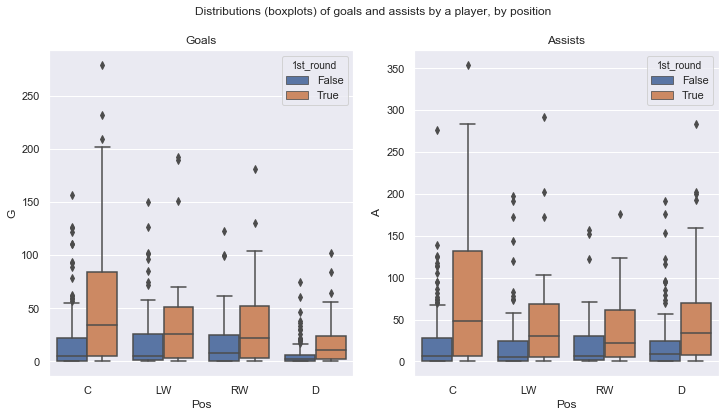

In [4]:
mask = df['Pos'] != 'G'
pos_order = ["C", "LW", "RW", "D"]

f, axes = plt.subplots(nrows=1, ncols=2,
                     figsize=(12, 6))
f.suptitle("Distributions (boxplots) of goals and assists by a player, by position")
sns.boxplot(data=df[mask], x='Pos', y='G',
            order=pos_order, hue='1st_round',
            ax=axes[0])
axes[0].set_title("Goals")

sns.boxplot(data=df[mask], x='Pos', y='A',
            order=pos_order, hue='1st_round',
            ax=axes[1])
axes[1].set_title("Assists");

## Normality test

Normality tests can be used to check if the data has a [Gaussian (normal) distribution](http://hyperphysics.phy-astr.gsu.edu/hbase/Math/gaufcn.html). 

* Gaussian distribution can serve as an appropriate approximation for physical events in cases when the number of events is very large. 
* It can provide an excellent approximation to a number of practical situations.
* The Gaussian distribution is a _continuous_ function which approximates the exact [binomial distribution](http://hyperphysics.phy-astr.gsu.edu/hbase/Math/disfcn.html#c2) of events.

The probability density function (PDF) of the normal distribution is defined as:

$ P(x) = \frac{1} {\sqrt{2 \sigma^2 \pi}}$$e^{ - \frac{(x - \mu)^2} {2 \sigma^2}}$

where $\mu$ is the mean and $\sigma$ is the standard deviation of the distribution. The function has its peak at the mean and its "spread" increases with the standard deviation.

### Calculating area under the normal curve
Area under the normal curve needs to be calculated to determine the probability that the value is within the range.

In [22]:
pos = 'RW'
mask = df['Pos'] == pos
s = df.loc[mask, 'G'].dropna
mu = s.mean()
sigma = s.std()
print("Players from position {0} "
      "scored on average {1:.2f} goals "
      "in total with a standard "
      "deviation of {2:.2f}."
      .format(pos, 
              mu,
              sigma))

Players from position RW scored on average 24.84 goals in total with a standard deviation of 33.83.


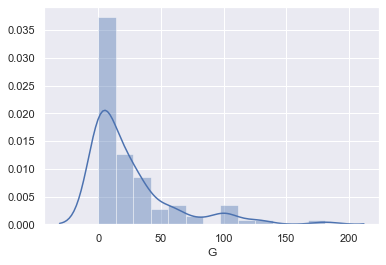

In [24]:
sns.distplot(s.dropna())

In [32]:
mask1 = df['Pos'] == 'C'
mask2 = df['G'] == 0
mask3 = df['1st_round'] == True
s_display_cols = ['name', 'Nat.', 'Pos', 
                  'Overall', 'Team', 'year',
                  'Amateur Team', 'GP', 'PTS', 'ppg']
df.loc[mask1 & mask2 & mask3, s_display_cols]

,name,Nat.,Pos,Overall,Team,year,Amateur Team,GP,PTS,ppg
437,Mark McNeill,CA,C,18,Chicago Blackhawks,2011,Prince Albert (WHL),2.0,0.0,0.000000
657,Henrik Samuelsson,US,C,27,Phoenix Coyotes,2012,Edmonton (WHL),3.0,0.0,0.000000
1484,Logan Brown,US,C,11,Ottawa Senators,2016,Windsor (OHL),4.0,1.0,0.250000
1693,Michael Rasmussen,CA,C,9,Detroit Red Wings,2017,Tri-City (WHL),8.0,1.0,0.125000
1704,Robert Thomas,CA,C,20,St. Louis Blues,2017,London (OHL),5.0,1.0,0.200000
1904,Jesperi Kotkaniemi,FI,C,3,Montreal Canadiens,2018,Assat (Finland),9.0,4.0,0.444444
1924,Isac Lundestrom,SE,C,23,Anaheim Ducks,2018,Lulea (Sweden),9.0,1.0,0.111111


In [33]:
df.head()

,id,Overall,Team,Player,Nat.,Pos,Age,To,Amateur Team,GP,G,A,PTS,+/-,PIM,GP.1,W,L,T/O,SV%,GAA,year,num_teams,round_ratio,round,1st_round,gpg,apg,ppg,name,alias,league
0,0,1,New York Islanders,John Tavares\tavarjo01,CA,C,18.0,2019.0,London (OHL),679.0,279.0,354.0,633.0,-39.0,311.0,NaN,NaN,NaN,NaN,NaN,NaN,2009,30,0.000000,1,True,0.410898,0.521355,0.932253,John Tavares,tavarjo01,OHL
1,1,2,Tampa Bay Lightning,Victor Hedman\hedmavi01,SE,D,18.0,2019.0,MoDo Ornskoldsvik ( ),634.0,84.0,284.0,368.0,63.0,491.0,NaN,NaN,NaN,NaN,NaN,NaN,2009,30,0.033333,1,True,0.132492,0.447950,0.580442,Victor Hedman,hedmavi01,
2,2,3,Colorado Avalanche,Matt Duchene\duchema01,CA,C,18.0,2019.0,Brampton (OHL),662.0,202.0,283.0,485.0,-85.0,158.0,NaN,NaN,NaN,NaN,NaN,NaN,2009,30,0.066667,1,True,0.305136,0.427492,0.732628,Matt Duchene,duchema01,OHL
3,3,4,Atlanta Thrashers,Evander Kane\kaneev01,CA,LW,18.0,2019.0,Vancouver (WCHL),583.0,190.0,173.0,363.0,-48.0,696.0,NaN,NaN,NaN,NaN,NaN,NaN,2009,30,0.100000,1,True,0.325901,0.296741,0.622642,Evander Kane,kaneev01,WCHL
4,4,5,Los Angeles Kings,Brayden Schenn\schenbr01,CA,C,18.0,2019.0,Brandon (WHL),524.0,140.0,185.0,325.0,-24.0,281.0,NaN,NaN,NaN,NaN,NaN,NaN,2009,30,0.133333,1,True,0.267176,0.353053,0.620229,Brayden Schenn,schenbr01,WHL
